$$\LARGE\textbf{ECON5811 Final Report} $$

$$\small\textbf{Daichengzhi|1155184716@link.cuhk.edu.hk} $$

$$\small\textbf{Luominghao|1155183588@link.cuhk.edu.hk} $$

$$\small\textbf{Liuxiaoyu|1155180314@link.cuhk.edu.hk} $$

$$\small\textbf{Huguiquan|1155183531@link.cuhk.edu.hk} $$

$$\normalsize\textbf{2023-05-18} $$

In this project, we have constructed a predictive framework using Lasso regression to forecast the following period's inflation rate through Consumer Price Index (CPI) and Producer Price Index (PPI) values. By employing methods such as Principal Component Analysis (PCA) and adding lag term, we let Lasso model can better predict the future inflation level. We have exploited larger, more complex datasets and capture more nuanced relationships in the data.In addition, we also adjusted the parameters to optimize the model to achieve the best predictive performance. Finally, we evaluated the performance of different models by conducting multiple tests.

$$\Large\textbf{I) Data&Introduction} $$

Our goal is to predict inflation, often measured by changing rate of the Consumer Price Index (CPI) and Consumer Price Index(PPI). Achieving our goal is actually dealing with time series data. The panel data have 152 varibles and 168 time period.

Firstly, we apply PCA on our dataset to reduce its dimensionality. PCA will transform the original variables into a smaller set of uncorrelated variables (principal components) while preserving the most significant variance in the data.Then we  use the retained principal components to transform our data. This transformation replaces the original variables with the reduced set of principal components, effectively reducing the dimensionality of the dataset. 

Secondly, we apply LASSO regression on the transformed dataset using the reduced set of principal components. LASSO helps in selecting a subset of the transformed variables (principal components) that are most relevant and have a significant impact on the outcome variable.

And then, we will adjust the parameters to optimize the model to achieve the best predictive performance.

Finally, we use our model to predict the CPI and evaluate our results.

In [11]:
#import our data and packages we use and set seed 
options(warn = 0)
load(url("https://github.com/zhentaoshi/Econ5821/raw/main/data_example/dataset_inf.Rdata"))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(glmnet))
suppressPackageStartupMessages(library(doParallel))
registerDoParallel(detectCores()-1)

set.seed(10)

In [12]:
#Lag=1:

# Merge the CPI and X data frames based on the 'month' column
data_1=merge(cpi,X,by="month",all = T)


# Add a new column 'y' representing the CPI value of the next month
data_1=data_1 |> mutate(y=lead(CPI))

$$\Large\textbf{II) Model Training Basic Method} $$

$$\normalsize\textbf{PCA} $$

In our dataset, we are dealing with a high-dimensional problem that consists of 152 variables, which are highly correlated. Such high-dimensional data can lead to what is referred to as the "curse of dimensionality." This term implies that as the dimensionality increases, the volume of the data grows exponentially, making it more challenging to train models effectively. Moreover, models trained on high-dimensional data are more prone to overfitting.

To tackle this issue, we propose using Principal Component Analysis (PCA), a popular dimensionality reduction technique. PCA has the ability to transform the original data into a set of new, orthogonal variables known as principal components. These principal components capture most of the variability in the original data while simultaneously reducing the data's dimensionality.

By reducing the data's dimensionality, we can improve computational efficiency, enhance data visualization, filter out noise, and avoid overfitting, all while retaining as much information as possible. As a result, PCA provides us with a more tractable, lower-dimensional representation of our data.



In [13]:
pca_data=data_1 |> select(!c("month","y","CPI"))
PCA=princomp(pca_data)
summary(PCA)

Importance of components:
                            Comp.1      Comp.2      Comp.3      Comp.4
Standard deviation     268.7636737 143.0231068 138.6440930 82.45258169
Proportion of Variance   0.5452118   0.1543962   0.1450864  0.05131361
Cumulative Proportion    0.5452118   0.6996079   0.8446944  0.89600800
                            Comp.5      Comp.6     Comp.7      Comp.8
Standard deviation     61.38072098 40.91835950 38.4059010 37.15638016
Proportion of Variance  0.02843728  0.01263748  0.0111332  0.01042056
Cumulative Proportion   0.92444528  0.93708276  0.9482160  0.95863652
                             Comp.9      Comp.10      Comp.11      Comp.12
Standard deviation     31.651042974 30.021974875 25.129617564 20.631205101
Proportion of Variance  0.007561364  0.006803033  0.004766459  0.003212723
Cumulative Proportion   0.966197883  0.973000916  0.977767375  0.980980098
                            Comp.13      Comp.14     Comp.15      Comp.16
Standard deviation     18.897905975 

We use 12 months of data to train the regression and one month to do the testing(rolling windows).

In [14]:

y_train=data_1[1:12,"y"]
y_test=data_1[13,"y"]
x_train=data_1[1:12,] |> select(!c("month","y"))
x_test=data_1[13,] |> select(!c("month","y"))

#Train the PCA model
pca_data=data_1 |> select(!c("month","y","CPI"))
PCA=princomp(pca_data)

#collect 8 Principal Components and train the lasso regression.
PC=predict(PCA,newdata = x_train)[,1:8]


From our PCA analysis, we observed that the first eight principal components account for over 95% of the variance in our data. We assume that all other dimensions are noises and the first 8 components contain all the information we need.
We acknowledge that our assumption classifying the remaining components as 'noise' may not be completely sound, our analysis based on the stability assumption of conditional expectations  $E(y_{t+1}|X_t)$ , but we believe our model can still provide a substantial prediction power.


$$\normalsize\textbf{LASSO} $$

Secondly, we apply LASSO regression on the transformed dataset using the reduced set of principal components. LASSO helps in selecting a subset of the transformed variables (principal components) that are most relevant and have a significant impact on the outcome variable.



$$\normalsize\text{Here is our model} $$
$$
E(y_{t+1}|X_t) =\alpha+  PC_t \beta  \quad t \in [i,i+12] \quad
$$
$$
y_{t+1} =\alpha+  PC_t \beta  + \epsilon
$$

for any int $i≥1$.

$\beta$ is the coefficient matrix and $\alpha$ is the intercept.



In [15]:
#collect 8 Principal Components and train the lasso regression.
PC=predict(PCA,newdata = x_train)[,1:8]

#Calculate scores for testing
PC_test=predict(PCA,newdata = x_test)[,1:8]

#Train the Lasso Regression: Find Lambda
cv_model <- cv.glmnet(PC, y_train, alpha = 1,nfolds = 3)
best_lambda <- cv_model$lambda.min

#display optimal lambda value
best_lambda

#view coefficients of best model
pca_lasso <- glmnet(PC, y_train, alpha = 1, lambda =best_lambda)
coef(pca_lasso)
summary(pca_lasso)

#make a prediction for the response value of a new observation
yp=predict(pca_lasso, s = best_lambda, newx = PC_test)[1,1]

yp
y_test

[1] 0.3043534

9 x 1 sparse Matrix of class "dgCMatrix"
                       s0
(Intercept)  1.012623e+02
Comp.1       3.674581e-05
Comp.2       .           
Comp.3       .           
Comp.4       .           
Comp.5       .           
Comp.6       1.893137e-03
Comp.7       1.628028e-02
Comp.8      -5.174814e-03

          Length Class     Mode   
a0        1      -none-    numeric
beta      8      dgCMatrix S4     
df        1      -none-    numeric
dim       2      -none-    numeric
lambda    1      -none-    numeric
dev.ratio 1      -none-    numeric
nulldev   1      -none-    numeric
npasses   1      -none-    numeric
jerr      1      -none-    numeric
offset    1      -none-    logical
call      5      -none-    call   
nobs      1      -none-    numeric

s1 
101.7285

[1] 102.1

prediction value is 101.728548151028 and real value is 101.728548151028

The intercept (Intercept) is 1.012623e+02, which means that when all independent variables (Comp.1 to Comp.8) are 0, the predicted result is 101.2623.

In the principal components Comp.1 to Comp.8, most of the coefficients are compressed to 0, which shows that Lasso regression successfully performs feature selection and eliminates those features that have little effect on the target variable. Only the four features Comp.1, Comp.6, Comp.7 and Comp.8 were preserved in the model.

The coefficient of Comp.1 is 3.674581e-05, which means that for every increase of one unit of Comp.1, the predicted result will increase by 0.00003674581 units.

The coefficient of Comp.6 is 1.893137e-03, which means that for every increase of one unit of Comp.6, the predicted result will increase by 0.001893137 units.

The coefficient of Comp.7 is 1.628028e-02, which means that for every additional unit of Comp.7, the predicted result will increase by 0.01628028 units.

The coefficient of Comp.8 is -5.174814e-03, which means that for every additional unit of Comp.8, the predicted result will decrease by 0.005174814 units.

The deviation ratio (dev.ratio) of the model is 0.304353356843454, which means that the model explains about 30.43% of the variability of the target variable. This ratio is too low and needs to be further adjusted.

$$\Large\textbf{III) Improvement of Model} $$

The idea that a lagged version of a variable can be predictive of its future values is often a useful idea in processing time series analysis.
CPI is a broad measure of price changes and prices often don't change drastically from month to month, and thus play an important role in predicting future CPI.
Base on the idea, we consider the inflation of one month will affect the next month so we introduced an alternative model that added the CPI of the month into the Lasso regression.

Based on more general model:\begin{aligned}E(y_{t}|X_{t-Lag})=\alpha+PC_{t-Lag}\beta+CPI_{t-Lag}*\beta\quad {t-Lag}\in[i,i+windowsize]\\ \end{aligned}

$$y_{t}=\alpha+PC_{t-Lag}\beta+CPI_{t-Lag}*\beta+\epsilon$$

We try to do some adjustment for the original model to improving our model.



Lag=1 means we use $X_t$ to predict $y_{t+1}$. 

To find the best lag to predict CPI and PPI, we also tried Lag=2 and Lag=3(a quarter) .

And then we tried PCA with 8, 9, and 10 dimensions to see if there are significant improvement. 

Combining all these differences, We tested 18 models in total.

$$\textbf{note:}$$

We are going to conduct an analysis using two distinct methods.

In the first method, we will not consider the past Consumer Price Index (CPI) as an individual explanatory variable. Instead, it will be incorporated as part of the dimension reduction process via Principal Component Analysis (PCA), which will then be used in the regression analysis.

The second method entails treating the CPI separately and utilizing it as an independent explanatory variable in our analysis.

We will be implementing tests using three lag values: 1, 2, and 3. This means we will evaluate the predictive potential of the data from the previous three months for both the CPI and the Producer Price Index (PPI). A 1-lag model suggests that the data from the immediately preceding period has the strongest influence in predicting the CPI and PPI for the current month. A 2-lag model indicates a stronger predictive power using data from the past two periods, and a 3-lag model suggests that data from the preceding three periods is most influential in forecasting the CPI and PPI for the current month. As we increase the lag, we consider a larger span of historical data in order to predict the current month's CPI and PPI. Selecting an appropriate lag, depending on the specific circumstances, can yield more accurate forecast results.

Additionally, we'll be using 8, 9, and 10 PCA components respectively in our analysis.

Thus, we test 2* 3 * 3 = 18 models.

The R-square is: 0.6414074 
The R-square is: 0.6377326 
The R-square is: 0.6309221 
The R-square is: 0.6304512 
The R-square is: 0.5203348 
The R-square is: 0.5379603 
The R-square is: 0.9314103 
The R-square is: 0.9272951 
The R-square is: 0.8725943 
The R-square is: 0.8784236 
The R-square is: 0.7978111 
The R-square is: 0.7876312 
[1] "Results:"
mean: 	 0.63957 	 0.6306866 	 0.5291476 	 0.9293527 	 0.875509 	 0.7927212 
stdev: 	 0.002598508 	 0.0003329482 	 0.01246312 	 0.002909856 	 0.004122001 	 0.007198264 
The R-square is: 0.6323295 
The R-square is: 0.6163082 
The R-square is: 0.6155294 
The R-square is: 0.613153 
The R-square is: 0.5396702 
The R-square is: 0.5337958 
The R-square is: 0.9275668 
The R-square is: 0.9228278 
The R-square is: 0.8795718 
The R-square is: 0.8903801 
The R-square is: 0.777807 
The R-square is: 0.809033 
[1] "Results:"
mean: 	 0.6243188 	 0.6143412 	 0.536733 	 0.9251973 	 0.884976 	 0.79342 
stdev: 	 0.01132877 	 0.001680386 	 0.004153839 	 0.003350

Warning message in par(new = TRUE):
“calling par(new=TRUE) with no plot”


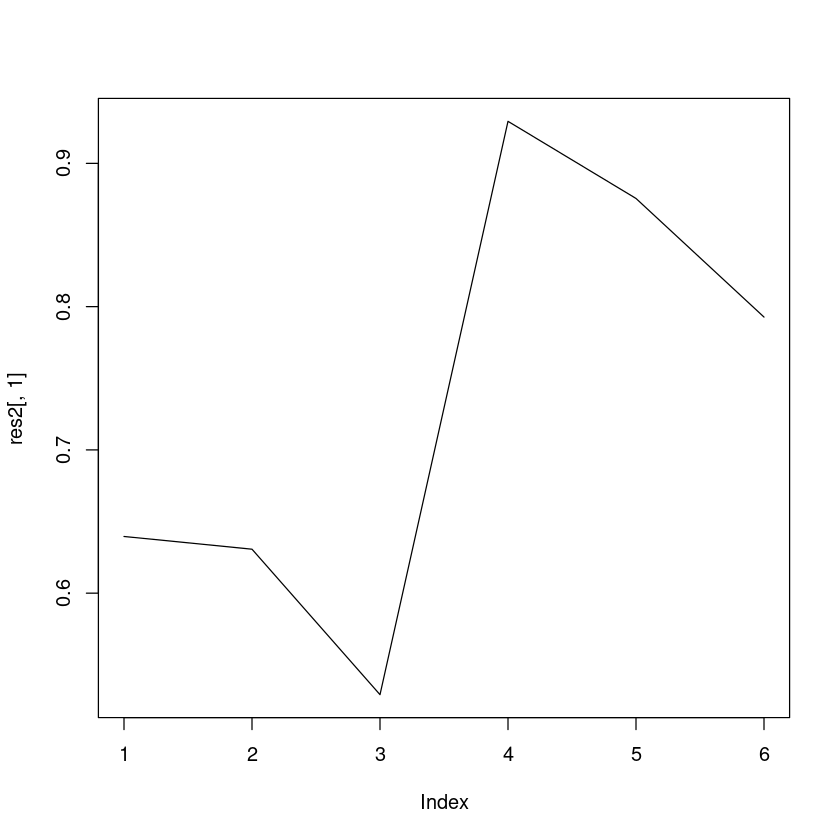

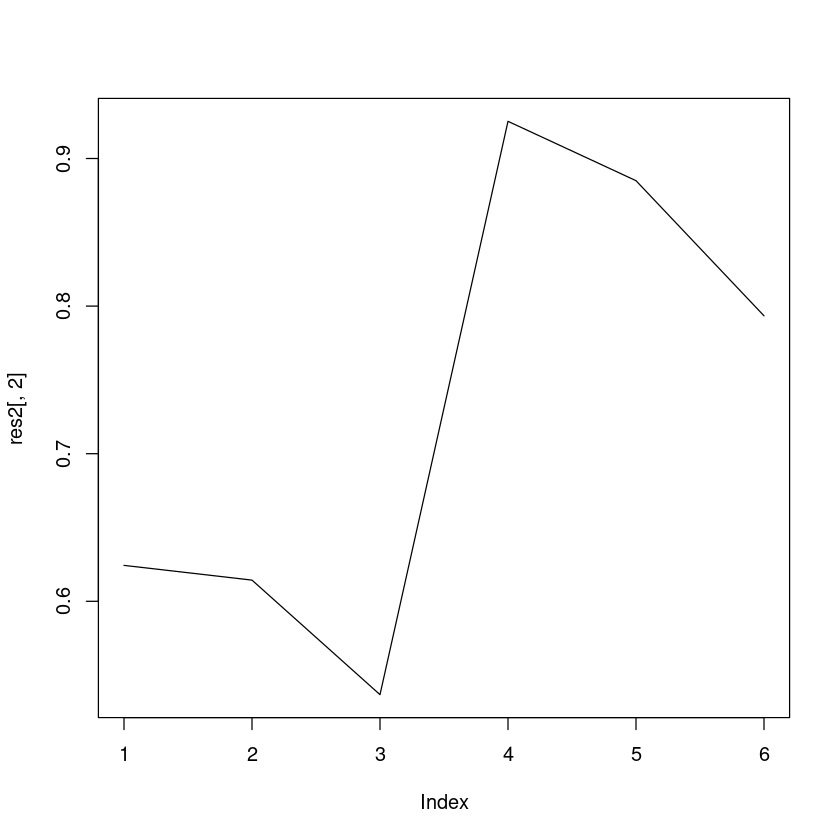

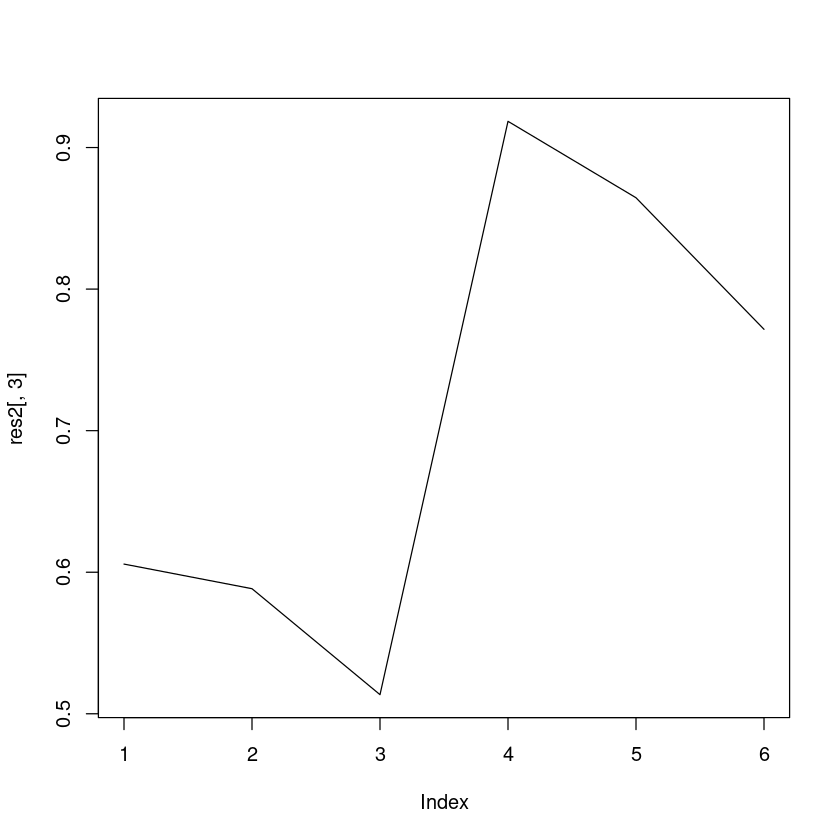

Saving 6.67 x 6.67 in image


Total duration: 

Time difference of 4.590154 mins

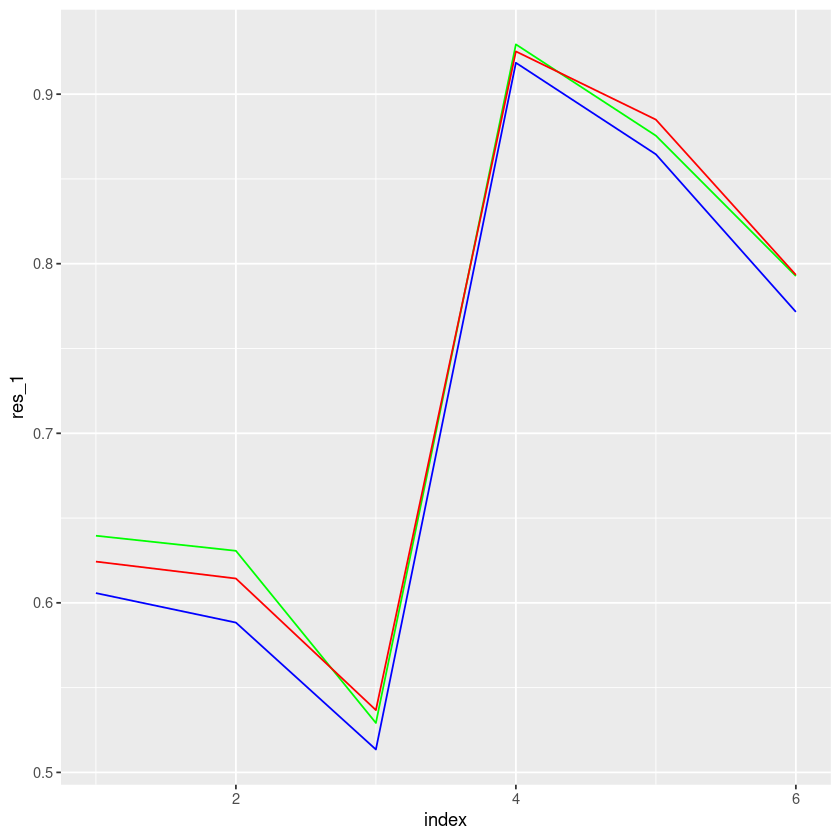

In [16]:
# Clear all objects
rm(list = ls())
n=2


load(url("https://github.com/zhentaoshi/Econ5821/raw/main/data_example/dataset_inf.Rdata"))


#-----------------Start-----------------#
st=Sys.time()

#Lag=1:
data_1=merge(cpi,X,by="month",all = T)
data_1=data_1 |> mutate(y=lead(CPI)) |> filter(is.na(y)==F)

#Lag=2:
data_2=merge(cpi,X,by="month",all = T)
data_2=data_2 |> mutate(y=lead(CPI,n=2)) |> filter(is.na(y)==F)

#Lag=3:
data_3=merge(cpi,X,by="month",all = T)
data_3=data_3 |> mutate(y=lead(CPI,n=3)) |> filter(is.na(y)==F)

#Train the PCA model
pca_data=X |> select(!c("month"))
PCA=princomp(pca_data)

##------------------------------#Functions:---------------------------##

pca_lasso_test <- function(i,data) {
  j=i+59
  k=i+60
  y_train=data[i:j,"y"]
  y_test=data[k,"y"]
  x_train=data[i:j,] |> select(!c("month","y"))
  x_test=data[k,] |> select(!c("month","y"))
  
  
  #collect 8 Principal Components and train the lasso regression.
  PC=predict(PCA,newdata = x_train)[,1:dim]
  
  #Calculate scores for testin
  PC_test=predict(PCA,newdata = x_test)[,1:dim]
  
  #find lambda
  cv_model <- cv.glmnet(PC, y_train, alpha = 1)
  best_lambda <- cv_model$lambda.min
  
  #display optimal lambda value
  best_lambda
  
  #view plot of test MSE's vs. lambda values
  
  #view coefficients of best model
  pca_lasso <- glmnet(PC, y_train, alpha = 1, lambda =best_lambda)
  coef(pca_lasso)
  summary(pca_lasso)
  
  #make a prediction for the response value of a new observation
  yp=predict(pca_lasso, s = best_lambda, newx = PC_test)[1,1]
  return(c(yp,y_test))
  
}

pca_lasso_test2 <- function(i,data) {
  j=i+59
  k=i+60
  y_train=data[i:j,"y"]
  y_test=data[k,"y"]
  x_train=data[i:j,] |> select(!c("month","y","CPI"))
  x_train_cpi=data[i:j,"CPI"] 
  x_test=data[k,] |> select(!c("month","y","CPI"))
  x_test_cpi=data[k,"CPI"]
  
  
  #collect 8 Principal Components and train the lasso regression.
  PC=predict(PCA,newdata = x_train)[,1:dim]
  PCs=cbind(PC,x_train_cpi)
  
  #Calculate scores for testing
  PC_test=predict(PCA,newdata = x_test)[,1:dim]
  PC_test2=append(PC_test,x_test_cpi)
  
  #find lambda
  cv_model <- cv.glmnet(PCs, y_train, alpha = 1,nfolds = 3)
  best_lambda <- cv_model$lambda.min
  
  #display optimal lambda value
  best_lambda
  
  #view coefficients of best model

  pca_lasso2 <- glmnet(PCs, y_train, alpha = 1, lambda =best_lambda)
  coef(pca_lasso2)
  summary(pca_lasso2)
  
  #make a prediction for the response value of a new observation

  yp=predict(pca_lasso2, s = best_lambda, newx = PC_test2)[1,1]
  return(c(yp,y_test))
  
}


rsquare_test <- function(yt,y_predicted) {
  sst <- sum((yt - mean(yt))^2)
  sse <- sum((y_predicted - yt)^2)
  
  rsq <- 1 - sse/sst
  
  cat("The R-square is:",rsq,"\n") 
  return(rsq)
}


#------------------------------

rep_test1 <- function(data){
  y_predicted=vector()
  yt=vector()
    
  ## Rolling window test
  for (x in 1:100) {

    results=pca_lasso_test(i = x,data)
    y_test = results[2]
    yp=results[1]
    y_predicted = append(y_predicted,yp)
    yt=append(yt,y_test)
  }
  rsquare_test(yt,y_predicted = y_predicted)
  
}

rep_test2 <- function(data){
  y_predicted=vector()
  yt=vector()
    
## Rolling window test
  for (x in 1:100)  {
    results=pca_lasso_test2(i=x,data)
    y_test = results[2]
    yp=results[1]
    y_predicted = append(y_predicted,yp)
    yt=append(yt,y_test)
  }
  rsquare_test(yt,y_predicted = y_predicted)
  
}


#---------------------Run test---------------------#

#------------------test 1----------------#
runtest <- function(){
    rsqv=c()
    for (t in 1:n) {

      rsqv=append(rsqv,rep_test1(data_1))

    }
    rcpi_1_1 <- rsqv

    #------------------test 2----------------#
    #Lag=2,method=1

    rsqv=c()
    for (t in 1:n){

      rsqv=append(rsqv,rep_test1(data_2))

    }
    rcpi_1_2 <- rsqv



    #------------------test 3----------------#
    #Lag=3,method=1

    rsqv=c()
    for (t in 1:n){

      rsqv=append(rsqv,rep_test1(data_3))

    }
    rcpi_1_3 <- rsqv

    #------------------test 4----------------#
    #Lag=1,method=2

    rsqv=c()
    for (t in 1:n){

      rsqv=append(rsqv,rep_test2(data_1))

    }

    rcpi_2_1 <- rsqv

    #------------------test 5----------------#
    #Lag=2,method=2

    rsqv=c()
    for (t in 1:n){

      rsqv=append(rsqv,rep_test2(data_2))

    }
    rcpi_2_2 <- rsqv



    #------------------test 6----------------#
    #Lag=3,method=2

    rsqv=c()
    for (t in 1:n){

      rsqv=append(rsqv,rep_test2(data_3))

    }
    rcpi_2_3 <- rsqv
    
    results <- matrix(data=c(mean(rcpi_1_1),mean(rcpi_1_2),mean(rcpi_1_3),
                             mean(rcpi_2_1),mean(rcpi_2_2),mean(rcpi_2_3),
                             sd(rcpi_1_1),sd(rcpi_1_2),sd(rcpi_1_3),
                             sd(rcpi_2_1),sd(rcpi_2_2),sd(rcpi_2_3)),
                      nrow = 2,ncol = 6,byrow = T)

    print("Results:")
    cat("mean: \t",mean(rcpi_1_1),"\t",mean(rcpi_1_2),"\t",mean(rcpi_1_3),"\t",mean(rcpi_2_1),
        "\t",mean(rcpi_2_2),"\t",mean(rcpi_2_3),"\n")
    cat("stdev: \t",sd(rcpi_1_1),"\t",sd(rcpi_1_2),"\t",sd(rcpi_1_3),"\t",sd(rcpi_2_1),"\t",sd(rcpi_2_2),
        "\t",sd(rcpi_2_3),"\n")
    
    return(results)
}    



##-----------------------------------------------------##
dim=8
res_1 <-runtest()[1,]
dim=9
res_2 <-runtest()[1,]
dim=10
res_3 <-runtest()[1,]

res=rbind(res_1,res_2,res_3)
res2=t(res)
par(new = TRUE)
plot(res2[,1],type = "l")
plot(res2[,2],type = "l")
plot(res2[,3],type = "l")

pl=data.frame(res2)
index=1:6
pl=cbind(pl,index)

ggplot(data = pl)+
  geom_line(color = "green", mapping=aes(y=res_1,x=index))+
  geom_line(color = "red", mapping=aes(y=res_2,x=index))+
  geom_line(color = "blue", mapping=aes(y=res_3,x=index))

ggsave(filename = "ResultsCPI_2.png")

ed=Sys.time()
dr=ed-st

cat("Total duration: ")
dr


$$\textbf{note:}$$

In our project the calculation of inflation rate is through:$$IR=\log(cpi_t) - \log(cpi_{t-12}))$$
IR means inflation rate

$$\text{Regarding the model for calculating inflation rates using CPI (Consumer Price Index) and PPI (Producer Price Index),}$$
$$\text{please refer to the "final_model_CPI_infl_rate.R" and "final_model_PPI_infl_rate.R" for detailed procedures.}$$


We have to point out we've explored in another model. In that model, we initially compute inflation rate, then use this inflation as the dependent variable 'y', and the preceding inflation values as the independent variable 'x', all while maintaining other variables constant. We've executed equivalent tests with that model which firstly calculate inflation rate, but the outcomes of that were less satisfactory in comparison to those we utilized the Consumer Price Index (CPI) as both the lag explanatory and dependent variables before we final predicting of inflation rate. 



$$\textbf{interpreting}$$
From graphs we know, Rsquare of index 4-5-6 are higher than Rsquare of index 1-2-3, which means the model where the lagged variable (CPI) is isolated as an explanatory variable performs superior to the model where it is incorporated directly in the Principal Component Analysis (PCA) dimension reduction. 
Isolating important variables before applying PCA can enhance the predictive capability of the model.

Following this approach, which involves training a model using CPI and then using the predicted CPI to estimate inflation rates, the final calculation of inflation proved more effective.


From the output, it appears that the best results are obtained when using the second method (method=2) and lag=1 (Lag=1) since it has the highest R-square value of 0.92935 with a dimension of 8. A higher R-squared value indicates a better fit for the model.

Thus, finally we choose the model below $$\textbf{Final model}$$

$$\text{The best model for CPI:"Lag=1, with CPI as independent variable, dim = 8, window size = 60"}$$

In [24]:
# Clear all objects
rm(list = ls())

#Final model for CPI:
#The best model for CPI:"Lag=1, with CPI as independent variable, dim = 8, window size = 60"

suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(glmnet))
suppressPackageStartupMessages(library(doParallel))
registerDoParallel(detectCores()-1)
set.seed(10)


windowlength=60
dim=8

load(url("https://github.com/zhentaoshi/Econ5821/raw/main/data_example/dataset_inf.Rdata"))
load(url("https://github.com/zhentaoshi/Econ5821/raw/main/data_example/data_oos.Rdata"))


#Lag=1 data:
data_1=rbind(X,real.X)
data_1=merge(rbind(cpi,real.cpi),data_1,by="month",all = T)
data_1=data_1 |> mutate(y=lead(CPI))

#Train the PCA model
pca_data=X |> select(!c("month"))
PCA=princomp(pca_data)

##------------------------------#Functions:---------------------------##

pca_lasso_test2 <- function(i,data) {
  a=windowlength-1
  b=windowlength
  
  j=i+a
  k=i+b
  y_train=data[i:j,"y"]
  y_test=data[k,"y"]
  x_train=data[i:j,] |> select(!c("month","y","CPI"))
  x_train_cpi=data[i:j,"CPI"] 
  x_test=data[k,] |> select(!c("month","y","CPI"))
  x_test_cpi=data[k,"CPI"]
  
  
  #collect Principal Components and train the lasso regression.
  PC=predict(PCA,newdata = x_train)[,1:dim]
  PCs=cbind(PC,x_train_cpi)
  
  #Calculate scores for testing
  PC_test=predict(PCA,newdata = x_test)[,1:dim]
  PC_test2=append(PC_test,x_test_cpi)
  
  #find lambda
  cv_model <- cv.glmnet(PCs, y_train, alpha = 1,nfolds = 3)
  best_lambda <- cv_model$lambda.min
  
  #display optimal lambda value
  best_lambda
  
  #view coefficients of best model
  
  pca_lasso2 <- glmnet(PCs, y_train, alpha = 1, lambda =best_lambda)
  coef(pca_lasso2)
  summary(pca_lasso2)
  
  #make a prediction for the response value of a new observation
  
  yp=predict(pca_lasso2, s = best_lambda, newx = PC_test2)[1,1]
  return(c((k+1),yp,y_test))
  
}


rsquare_test <- function(yt,y_predicted) {
  sst <- sum((yt - mean(yt))^2)
  sse <- sum((y_predicted - yt)^2)
  
  rsq <- 1 - sse/sst
  
  cat("The R-square is:",rsq,"\n") 
  return(rsq)
}

rep_test2 <- function(data){
  
  ## Rolling window test
  result <-foreach (x = 1:(197-windowlength),.combine = "rbind") %dopar% {
    pca_lasso_test2(i = x,data)
  }
  result=data.frame(result)
  colnames(result) <- c("month","CPI_predicted","CPI_true")
  return(result)
  
}

result <- rep_test2(data_1)

## Test the prediction out of sample R Square


yp=result[result$month %in% 1:198,]$CPI_predicted
yt=result[result$month %in% 1:198,]$CPI_true

#R-Square of price prediction
print("R-Square of CPI:")
rsquare_test(yt,yp)

## calculate inflation rate

result=result |> mutate(inflation_predicted=log(CPI_predicted)-log(lag(CPI_true,n=12)),
                        inflation_true=log(CPI_true)-log(lag(CPI_true,n=12))
                        )
result2=result |> filter(is.na(inflation_predicted)==F)

inf_p=result2[result2$month %in% 1:198,]$inflation_predicted
inf_t=result2[result2$month %in% 1:198,]$inflation_true

#R-Square of inflation
print("R-Square of inflation rate:")
rsquare_test(inf_t,inf_p)

###Result2 is the final answer
resultCPI=result2


[1] "R-Square of CPI:"
The R-square is: 0.9124924 


[1] 0.9124924

[1] "R-Square of inflation rate:"
The R-square is: 0.9673493 


[1] 0.9673493

$$\textbf{note:}$$The first R-squared value  refers to the R-squared of the price prediction. This is evaluating how well our model is able to predict the CPI values in the test data. It measures the proportion of the variance in the observed CPI values that can be explained by the model.

The second R-squared value refers to the R-squared of the inflation prediction. In this case, the model is predicting inflation (calculated as the logarithmic difference of CPI values over a 12 month period). It measures the proportion of the variance in the observed inflation values that can be explained by the model.

$$\textbf{interpreting}$$


The first R-squared value refers to the R-squared of the CPI prediction. It is 0.9124924, which suggests that about 91.24% of the variability in the future CPI values can be explained by our model.

The second R-squared value refers to the R-squared of the inflation prediction. It is 0.9673493, which suggests that about 96.73% of the variability in the future inflation rate values can be explained by our model.

Note: each time we run the file, the results will be slightly different.

$$\Large\textbf{Iv) Predict PPI} $$

Just like the process mentioned above, we also predict PPI.

$$\normalsize\textbf{Repeat Testing} $$



In [18]:
# Clear all objects
rm(list = ls())


n=2
set.seed(10)

load(url("https://github.com/zhentaoshi/Econ5821/raw/main/data_example/dataset_inf.Rdata"))


#-----------------Start-----------------#
st=Sys.time()

#Lag=1:
data_1=merge(ppi,X,by="month",all = T)
data_1=data_1 |> mutate(y=lead(PPI)) |> filter(is.na(y)==F)

#Lag=2:
data_2=merge(ppi,X,by="month",all = T)
data_2=data_2 |> mutate(y=lead(PPI,n=2)) |> filter(is.na(y)==F)

#Lag=3:
data_3=merge(ppi,X,by="month",all = T)
data_3=data_3 |> mutate(y=lead(PPI,n=3)) |> filter(is.na(y)==F)

#Train the PCA model
pca_data=X |> select(!c("month"))
PCA=princomp(pca_data)

##------------------------------#Functions:---------------------------##

pca_lasso_test <- function(i,data) {
  j=i+83
  k=i+84
  y_train=data[i:j,"y"]
  y_test=data[k,"y"]
  x_train=data[i:j,] |> select(!c("month","y"))
  x_test=data[k,] |> select(!c("month","y"))
  
  
  #collect 8 Principal Components and train the lasso regression.
  PC=predict(PCA,newdata = x_train)[,1:dim]
  
  #Calculate scores for testin
  PC_test=predict(PCA,newdata = x_test)[,1:dim]
  
  #find lambda
  cv_model <- cv.glmnet(PC, y_train, alpha = 1)
  best_lambda <- cv_model$lambda.min
  
  #display optimal lambda value
  best_lambda
  
  #view plot of test MSE's vs. lambda values
  
  #view coefficients of best model
  pca_lasso <- glmnet(PC, y_train, alpha = 1, lambda =best_lambda)
  coef(pca_lasso)
  summary(pca_lasso)
  
  #make a prediction for the response value of a new observation
  yp=predict(pca_lasso, s = best_lambda, newx = PC_test)[1,1]
  return(c(yp,y_test))
  
}

pca_lasso_test2 <- function(i,data) {
  j=i+83
  k=i+84
  y_train=data[i:j,"y"]
  y_test=data[k,"y"]
  x_train=data[i:j,] |> select(!c("month","y","PPI"))
  x_train_PPI=data[i:j,"PPI"] 
  x_test=data[k,] |> select(!c("month","y","PPI"))
  x_test_PPI=data[k,"PPI"]
  
  
  #collect 8 Principal Components and train the lasso regression.
  PC=predict(PCA,newdata = x_train)[,1:dim]
  PCs=cbind(PC,x_train_PPI)
  
  #Calculate scores for testing
  PC_test=predict(PCA,newdata = x_test)[,1:dim]
  PC_test2=append(PC_test,x_test_PPI)
  
  #find lambda
  cv_model <- cv.glmnet(PCs, y_train, alpha = 1,nfolds = 3)
  best_lambda <- cv_model$lambda.min
  
  #display optimal lambda value
  best_lambda
  
  #view coefficients of best model
  
  pca_lasso2 <- glmnet(PCs, y_train, alpha = 1, lambda =best_lambda)
  coef(pca_lasso2)
  summary(pca_lasso2)
  
  #make a prediction for the response value of a new observation
  
  yp=predict(pca_lasso2, s = best_lambda, newx = PC_test2)[1,1]
  return(c(yp,y_test))
  
}


rsquare_test <- function(yt,y_predicted) {
  sst <- sum((yt - mean(yt))^2)
  sse <- sum((y_predicted - yt)^2)
  
  rsq <- 1 - sse/sst
  
  return(rsq)
}


#------------------------------

rep_test1 <- function(data){
  y_predicted=vector()
  yt=vector()
  
## Rolling window test
  for (x in 1:80) {
    
    results=pca_lasso_test(i = x,data)
    y_test = results[2]
    yp=results[1]
    y_predicted = append(y_predicted,yp)
    yt=append(yt,y_test)
  }
  rsquare_test(yt,y_predicted = y_predicted)
  
}

rep_test2 <- function(data){
  y_predicted=vector()
  yt=vector()
  
  for (x in 1:80)  {
    results=pca_lasso_test2(i=x,data)
    y_test = results[2]
    yp=results[1]
    y_predicted = append(y_predicted,yp)
    yt=append(yt,y_test)
  }
  rsquare_test(yt,y_predicted = y_predicted)
  
}


#---------------------Run test---------------------#

#------------------test 1----------------#
runtest <- function(){
  rsqv=c()
  for (t in 1:n) {
    
    rsqv=append(rsqv,rep_test1(data_1))
    
  }
  rPPI_1_1 <- rsqv
  
  #------------------test 2----------------#
  #Lag=2,method=1
  
  rsqv=c()
  for (t in 1:n){
    
    rsqv=append(rsqv,rep_test1(data_2))
    
  }
  rPPI_1_2 <- rsqv
  
  
  
  #------------------test 3----------------#
  #Lag=3,method=1
  
  rsqv=c()
  for (t in 1:n){
    
    rsqv=append(rsqv,rep_test1(data_3))
    
  }
  rPPI_1_3 <- rsqv
  
  #------------------test 4----------------#
  #Lag=1,method=2
  
  rsqv=c()
  for (t in 1:n){
    
    rsqv=append(rsqv,rep_test2(data_1))
    
  }
  
  rPPI_2_1 <- rsqv
  
  #------------------test 5----------------#
  #Lag=2,method=2
  
  rsqv=c()
  for (t in 1:n){
    
    rsqv=append(rsqv,rep_test2(data_2))
    
  }
  rPPI_2_2 <- rsqv
  
  
  
  #------------------test 6----------------#
  #Lag=3,method=2
  
  rsqv=c()
  for (t in 1:n){
    
    rsqv=append(rsqv,rep_test2(data_3))
    
  }
  rPPI_2_3 <- rsqv
  
  results <- matrix(data=c(mean(rPPI_1_1),mean(rPPI_1_2),mean(rPPI_1_3),
                           mean(rPPI_2_1),mean(rPPI_2_2),mean(rPPI_2_3),
                           sd(rPPI_1_1),sd(rPPI_1_2),sd(rPPI_1_3),
                           sd(rPPI_2_1),sd(rPPI_2_2),sd(rPPI_2_3)),
                    nrow = 2,ncol = 6,byrow = T)
  
  print("Results:")
  cat("mean: \t",mean(rPPI_1_1),"\t",mean(rPPI_1_2),"\t",mean(rPPI_1_3),"\t",mean(rPPI_2_1),
      "\t",mean(rPPI_2_2),"\t",mean(rPPI_2_3),"\n")
  cat("stdev: \t",sd(rPPI_1_1),"\t",sd(rPPI_1_2),"\t",sd(rPPI_1_3),"\t",sd(rPPI_2_1),"\t",sd(rPPI_2_2),
      "\t",sd(rPPI_2_3),"\n")
  
  return(results)
}    



##-----------------------------------------------------##
dim=8
res_1 <-runtest()[1,]
dim=9
res_2 <-runtest()[1,]
dim=10
res_3 <-runtest()[1,]

res=rbind(res_1,res_2,res_3)
res2=t(res)

pl=data.frame(res2)
index=1:6
pl=cbind(pl,index)

ed=Sys.time()
dr=ed-st

cat("Total duration: ")
dr


[1] "Results:"
mean: 	 0.8469282 	 0.8375837 	 0.812336 	 0.9778174 	 0.9308155 	 0.8833201 
stdev: 	 0.001507237 	 0.002870251 	 0.001518531 	 0.0005862627 	 0.0005991799 	 0.003879919 
[1] "Results:"
mean: 	 0.8443679 	 0.8275112 	 0.7936187 	 0.9776933 	 0.9296869 	 0.8766476 
stdev: 	 0.001643988 	 0.00464781 	 0.002953168 	 0.0002742197 	 0.002813622 	 0.004623059 
[1] "Results:"
mean: 	 0.848081 	 0.8255054 	 0.7988572 	 0.9766742 	 0.9337043 	 0.8835255 
stdev: 	 0.001612682 	 0.0005926555 	 0.002785958 	 0.001009945 	 0.002879024 	 0.004575945 


Warning message in par(new = TRUE):
“calling par(new=TRUE) with no plot”


Total duration: 

Time difference of 8.079859 mins

In [19]:
pl

res_1,res_2,res_3,index
<dbl>,<dbl>,<dbl>,<int>
0.8469282,0.8443679,0.8480810,1
0.8375837,0.8275112,0.8255054,2
0.8123360,0.7936187,0.7988572,3
0.9778174,0.9776933,0.9766742,4
0.9308155,0.9296869,0.9337043,5
0.8833201,0.8766476,0.8835255,6


From the 3 results we know, Rsquare of index 4-5-6 are higher than Rsquare of index 1-2-3, which means the model where the lagged variable (PPI) is isolated as an explanatory variable performs superior to the model where it is incorporated directly in the Principal Component Analysis (PCA) dimension reduction. 

Isolating PPI before applying PCA can enhance the predictive capability of the model.

Following this approach, which involves training a model using PPI and then using the predicted PPI to estimate inflation rates, the final calculation of inflation proved more effective.

From the output, lag=1(Lag=1),method=2(method=2) and dimension=8 are the best parameters, by find its Rsquare 0.9778174 is the best.

$$\normalsize\textbf{Final Model} $$



$$\normalsize\text{The best model for PPI:"Lag=1, with PPI as independent variable, dim =8, window size = 84} $$


In [20]:
#Final model for PPI:
#The best model for PPI:"Lag=1, with PPI as independent variable, dim = 8, window size = 84"

#Perequisite
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(glmnet))
suppressPackageStartupMessages(library(doParallel))
registerDoParallel(detectCores()-1)
set.seed(10)

dim=8
windowlength=84

load(url("https://github.com/zhentaoshi/Econ5821/raw/main/data_example/dataset_inf.Rdata"))
load(url("https://github.com/zhentaoshi/Econ5821/raw/main/data_example/data_oos.Rdata"))


#Lag=1 data:
data_1=rbind(X,real.X)
data_1=merge(rbind(ppi,real.ppi),data_1,by="month",all = T)
data_1=data_1 |> mutate(y=lead(PPI))

#Train the PCA model
pca_data=X |> select(!c("month"))
PCA=princomp(pca_data)

##------------------------------#Functions:---------------------------##

pca_lasso_test2 <- function(i,data) {
  a=windowlength-1
  b=windowlength
  
  j=i+a
  k=i+b
  y_train=data[i:j,"y"]
  y_test=data[k,"y"]
  x_train=data[i:j,] |> select(!c("month","y","PPI"))
  x_train_ppi=data[i:j,"PPI"] 
  x_test=data[k,] |> select(!c("month","y","PPI"))
  x_test_ppi=data[k,"PPI"]
  
  
  #collect Principal Components and train the lasso regression.
  PC=predict(PCA,newdata = x_train)[,1:dim]
  PCs=cbind(PC,x_train_ppi)
  
  #Calculate scores for testing
  PC_test=predict(PCA,newdata = x_test)[,1:dim]
  PC_test2=append(PC_test,x_test_ppi)
  
  #find lambda
  cv_model <- cv.glmnet(PCs, y_train, alpha = 1,nfolds = 3)
  best_lambda <- cv_model$lambda.min
  
  #display optimal lambda value
  best_lambda
  
  #view coefficients of best model
  
  pca_lasso2 <- glmnet(PCs, y_train, alpha = 1, lambda =best_lambda)
  coef(pca_lasso2)
  summary(pca_lasso2)
  
  #make a prediction for the response value of a new observation
  
  yp=predict(pca_lasso2, s = best_lambda, newx = PC_test2)[1,1]
  return(c((k+1),yp,y_test))
  
}


rsquare_test <- function(yt,y_predicted) {
  sst <- sum((yt - mean(yt))^2)
  sse <- sum((y_predicted - yt)^2)
  
  rsq <- 1 - sse/sst
  
  cat("The R-square is:",rsq,"\n") 
  return(rsq)
}

rep_test2 <- function(data){

    ## Rolling window test
  result <-foreach (x = 1:113,.combine = "rbind") %dopar% {
    pca_lasso_test2(i = x,data)
  }
  result=data.frame(result)
  colnames(result) <- c("month","PPI_predicted","PPI_true")
  return(result)
  
}

result <- rep_test2(data_1)
yp=result[result$month %in% 169:198,]$PPI_predicted
yt=result[result$month %in% 169:198,]$PPI_true

#R-Square of price prediction
print("The R-Square of PPI:")
rsquare_test(yt,yp)

result=result |> mutate(inflation_predicted=log(PPI_predicted)-log(lag(PPI_true,n=12)),
                        inflation_true=log(PPI_true)-log(lag(PPI_true,n=12))
                        )
result2=result |> filter(is.na(inflation_predicted)==F)


inf_p=result2[result2$month %in% 169:198,]$inflation_predicted
inf_t=result2[result2$month %in% 169:198,]$inflation_true

#R-Square of inflation
print("The R-Square of inflation rate:")
rsquare_test(inf_t,inf_p)

###Result2 is the final answer
resultPPI=result2[result2$month %in% 169:198,]

[1] "The R-Square of PPI:"
The R-square is: 0.9051203 


[1] 0.9051203

[1] "The R-Square of inflation rate:"
The R-square is: 0.9849115 


[1] 0.9849115

The first R-squared value refers to the R-squared of the PPI (Producer Price Index) prediction. It is 0.9051203 , which suggests that about 90.51% of the variability in future PPI values can be explained by our model.

The second R-squared value refers to the R-squared of the inflation prediction. It is 0.9849115, which suggests that about 98.45% of the variability in future inflation rate values can be explained by our model.

Note: each time we run the file, the results will be slightly different.

$$\Large\textbf{V) Results} $$

The best model for CPI:"Lag=1, with CPI as independent variable, dim = 8, window size = 60 The best model for PPI:"Lag=1, with PPI as independent variable, dim = 8, window size =84

Interestingly, we observed that both models shared the exact same optimal parameters of PCA dimensions and Lag. This consistency across two distinct economic indices - CPI and PPI - speaks to the robustness of our modeling approach. And it also suggests that both CPI and PPI share similar dynamic characteristics in their relationship with the predictor variables in our data set.

With both CPI and PPI having the best model performance at lag=1, this indicates that the previous month's data is most predictive of the current month for both indices. This means the short-term past, i.e., the immediate previous period, is significant in predicting both CPI and PPI.

With dimension=8 being optimal for both, this suggests that the same level of complexity (in terms of number of principal components in PCA) is suitable for capturing the major variations in both datasets.

The optimal window size=60 suggests that using the past 60 periods of data provides the most useful information for predicting the next period for CPI. And the window size of the Producer Price Index (PPI) is larger than that of the Consumer Price Index (CPI), this would imply that the PPI is more influenced by historical data than the CPI.



CPI final results:

In [25]:
resultCPI

,month,CPI_predicted,CPI_true,inflation_predicted,inflation_true
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
result.13,74,100.44327,98.40,-0.0789987098,-0.099550990
result.14,75,97.61108,98.80,-0.1039141579,-0.091807549
result.15,76,98.58029,98.50,-0.0958788508,-0.096693625
result.16,77,98.53969,98.60,-0.0888901327,-0.088278323
result.17,78,98.53238,98.30,-0.0833777150,-0.085738950
result.18,79,98.50657,98.20,-0.0761420557,-0.079259070
result.19,80,98.43602,98.80,-0.0636007368,-0.059909911
result.20,81,98.95939,99.20,-0.0554339811,-0.053005537
result.21,82,99.38634,99.50,-0.0453761823,-0.044233255


PPI final results:

In [22]:
resultPPI

,month,PPI_predicted,PPI_true,inflation_predicted,inflation_true
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
result.84,169,104.94485,106.9,0.1025097796,0.120968647
result.85,170,106.57538,107.8,0.1139235499,0.125348689
result.86,171,107.79145,107.6,0.1191890551,0.117411358
result.87,172,107.39421,106.4,0.1057204915,0.096419818
result.88,173,106.03216,105.5,0.0869717028,0.081940241
result.89,174,105.14156,105.5,0.0764814086,0.079884742
result.90,175,105.19959,105.5,0.0678353902,0.070686926
result.91,176,105.23903,106.3,0.0590962685,0.069127271
result.92,177,106.22769,106.9,0.0594151368,0.065724132


$$\large\textbf{IV) Reflection and conclusion}$$


We have developed a predictive framework utilizing Lasso regression to predict the values of the Consumer Price Index (CPI) and Producer Price Index (PPI) for the upcoming period. Our model presents a better performance compared to original basic LASSO model, by integrating components from principal component analysis (PCA) and taking into account lag variables. These adjustments allow us to take advantage of larger, more complex datasets and grasp more subtle relationships within the data.

We have fine-tuned the parameters to optimize our model for the best predictive performance. Multiple tests were conducted to assess and compare the performance of various models. Interestingly, both CPI and PPI models were found to share the same optimal parameters: Lag = 1, PCA dimensions = 8, CPI window size = 60 and PPI window size = 84 respectively.

A lag of 1 indicates that the previous month's data provides the most predictive power for the current month for both indices, underlining the importance of short-term past data in predicting CPI and PPI.The optimal number of PCA dimensions being 8 for both suggests that the same degree of complexity is adequate in capturing the key variations in both datasets.Similarly, the optimal window size being consistent at 60 periods implies that using the past 60 periods of data yields the most relevant information for predicting the following period for both CPI and PPI.

In conclusion, our approach to Lasso regression, supplemented with PCA components and lag variables, has shown promising results in forecasting CPI and PPI values. The consistency of optimal parameters across the two indices speaks to the potential stability and applicability of our model, providing a solid foundation for further exploration in the field of economic forecasting.